In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
a = 1
import numpy as np

In [9]:
parameter_set = prior.sample((3,))

In [10]:
p = np.array_split(parameter_set, 3)

In [17]:
len(parameter_set)

3

In [16]:
p[2].loc[0]

KeyError: 0

In [4]:
parameter_set.iloc[0]

AB/PD     Na       236.475113
          CaT        5.001752
          CaS        6.070589
          A         57.219791
          KCa       13.460739
          Kd       110.183891
          H          0.014565
          Leak       0.000629
LP        Na        31.008839
          CaT        2.162581
          CaS       11.752544
          A         25.517145
          KCa        9.083657
          Kd       123.397957
          H          0.023155
          Leak       0.031273
PY        Na       397.170776
          CaT       11.859902
          CaS        1.473160
          A         58.609161
          KCa        2.704818
          Kd       142.555054
          H          0.041542
          Leak       0.035276
Synapses  AB-LP     -6.052121
          PD-LP     -8.451645
          AB-PY     -7.886857
          PD-PY    -17.997303
          LP-PD    -10.336865
          LP-PY    -13.810649
          PY-LP    -13.749743
Name: 0, dtype: float32

In [1]:
from pyloric import simulate, create_prior, summary_stats
prior = create_prior()
parameter_set = prior.sample((1,))
simulation_output = simulate(parameter_set.loc[0])
summary_statistics = summary_stats(simulation_output)

In file included from /home/mdeistler57/anaconda3/envs/tsnpe/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1960:0,
                 from /home/mdeistler57/anaconda3/envs/tsnpe/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/mdeistler57/anaconda3/envs/tsnpe/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/mdeistler57/.pyxbld/temp.linux-x86_64-3.8/pyrex/pyloric/simulator.c:688:
/home/mdeistler57/anaconda3/envs/tsnpe/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it with " \
  ^~~~~~~
/home/mdeistler57/.pyxbld/temp.linux-x86_64-3.8/pyrex/pyloric/simulator.c: In function ‘__pyx_pf_7pyloric_9simulator_sim_time’:
/home/mdeistler57/.pyxbld/temp.linux-x86_64-3.8/pyre

In [2]:
parameter_set

AB/PD                                                                  \
           Na       CaT       CaS          A        KCa          Kd         H   
0  236.475113  5.001752  6.070589  57.219791  13.460739  110.183891  0.014565   

                    LP            ...          PY                      \
       Leak         Na       CaT  ...          Kd         H      Leak   
0  0.000629  31.008839  2.162581  ...  142.555054  0.041542  0.035276   

   Synapses                                                                  
      AB-LP     PD-LP     AB-PY      PD-PY      LP-PD      LP-PY      PY-LP  
0 -6.052121 -8.451645 -7.886857 -17.997303 -10.336865 -13.810649 -13.749743  

[1 rows x 31 columns]

In [4]:
import torch
import matplotlib.pyplot as plt
from torch import ones, zeros, eye, as_tensor, tensor, float32
import matplotlib as mpl
import numpy as np
from torch.distributions import MultivariateNormal
from sbi.utils import BoxUniform

In [5]:
from l5pc.utils.common_utils import (
    load_prior,
    extract_bounds,
    load_posterior,
)
from l5pc.utils.model_utils import (
    replace_nan,
    add_observation_noise,
)
from l5pc.model.utils import return_gt, return_x_names, return_names
import pandas as pd
from sbi.analysis import pairplot

Connecting root@134.2.168.121:3306


In [6]:
from l5pc.model import L5PC_20D_theta, L5PC_20D_x, summstats_l5pc

In [71]:
from sbi.analysis import pairplot, marginal_plot

In [149]:
from l5pc.model.simulator import setup_l5pc, simulate_l5pc
from l5pc.model.summstats import summstats_l5pc

In [7]:
from l5pc.utils.evaluation_utils import (
    predictive_traces,
    plot_traces,
    plot_summstats,
    compare_gt_log_probs,
    gt_log_prob,
    coverage,
    plot_coverage,
)

In [148]:
setup_l5pc()

Loading neuron libraries
Successfully loaded libraries!


In [150]:
name = "2022_04_27__17_56_34_snpe"
id_ = "l20_1"
inference, posterior, used_features, round_ = load_posterior(id_, name)

In [151]:
data_id = "l20_0" if round_ == 1 else id_
print("data id: ", data_id)

data id:  l20_1


In [152]:
x_db = L5PC_20D_x()
theta_db = L5PC_20D_theta()

In [153]:
theta = as_tensor(
    np.asarray(
        (theta_db & {"round": round_} & {"id": id_}).fetch(*return_names())
    ),
    dtype=float32,
).T
x = as_tensor(
    np.asarray(
        (x_db & {"round": round_} & {"id": id_}).fetch(*return_x_names())
    ),
    dtype=float32,
).T

In [156]:
# trace = simulate_l5pc()

In [157]:
x, _ = replace_nan(x)

In [158]:
prior = load_prior("l20_1")
lower = prior.prior_torch.support.base_constraint.lower_bound
upper = prior.prior_torch.support.base_constraint.upper_bound
limits = torch.stack([lower, upper]).T

In [159]:
x_pd = pd.DataFrame(x[-1000:].numpy(), columns=return_x_names())

x = x[-1000:]
theta = theta[-1000:]
x, _ = replace_nan(x)

In [160]:
x = add_observation_noise(
    x=x,
    id_="l20_1",
    noise_multiplier=0.0,
    std_type="data",
    subset=None,
)

Adding observation noise according to  data


In [161]:
ind = 1
posterior = posterior.set_default_x(x[ind:ind+1])
samples = posterior.sample((1000,))
log_probs = posterior.log_prob(samples)
gt_log_prob = posterior.log_prob(theta[ind:ind+1])

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/mdeistler57/anaconda3/envs/tsnpe/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


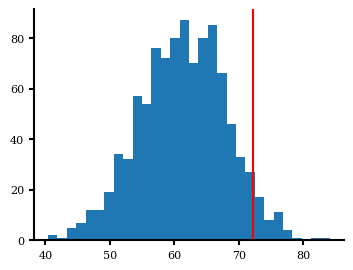

In [162]:
with mpl.rc_context(fname="/mnt/qb/macke/mdeistler57/tsnpe_collection/l5pc/.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    _ = ax.hist(log_probs.numpy(), bins=30)
    ax.axvline(gt_log_prob, color="r")

In [163]:
alpha, cov = coverage(posterior, theta, x, used_features)

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

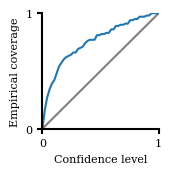

In [164]:
with mpl.rc_context(fname="/mnt/qb/macke/mdeistler57/tsnpe_collection/l5pc/.matplotlibrc"):
    plot_coverage(alpha, cov)

## Evaluate posterior for actual x_o

In [144]:
inference, posterior, used_features, round_ = load_posterior(id_, name)

In [145]:
samples = posterior.sample((1000,))
log_probs = posterior.log_prob(samples)
gt = as_tensor(return_gt().to_numpy(), dtype=float32)
gt_log_prob = posterior.log_prob(gt)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/mdeistler57/anaconda3/envs/tsnpe/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


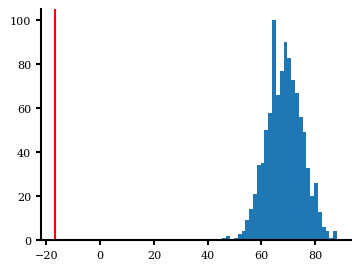

In [146]:
with mpl.rc_context(fname="/mnt/qb/macke/mdeistler57/tsnpe_collection/l5pc/.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    _ = ax.hist(log_probs.numpy(), bins=30)
    ax.axvline(gt_log_prob, color="r")